In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [13]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

In [15]:
# View all of the classes that automap found
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [16]:
# Inspect column names and data types for measurement table
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [17]:
# Inspect column names and data types for station table
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [18]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [19]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [27]:
# Find the most recent date in the data set.
recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first().date
recent_date

'2017-08-23'

In [ ]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 

In [28]:
# Starting from the most recent data point in the database.
recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first().date
recent_date

'2017-08-23'

In [36]:
# Calculate the date one year from the last date in data set.
last_year = dt.datetime.strptime(recent_date, '%Y-%m-%d') - dt.timedelta(days=365)
last_year

datetime.datetime(2016, 8, 23, 0, 0)

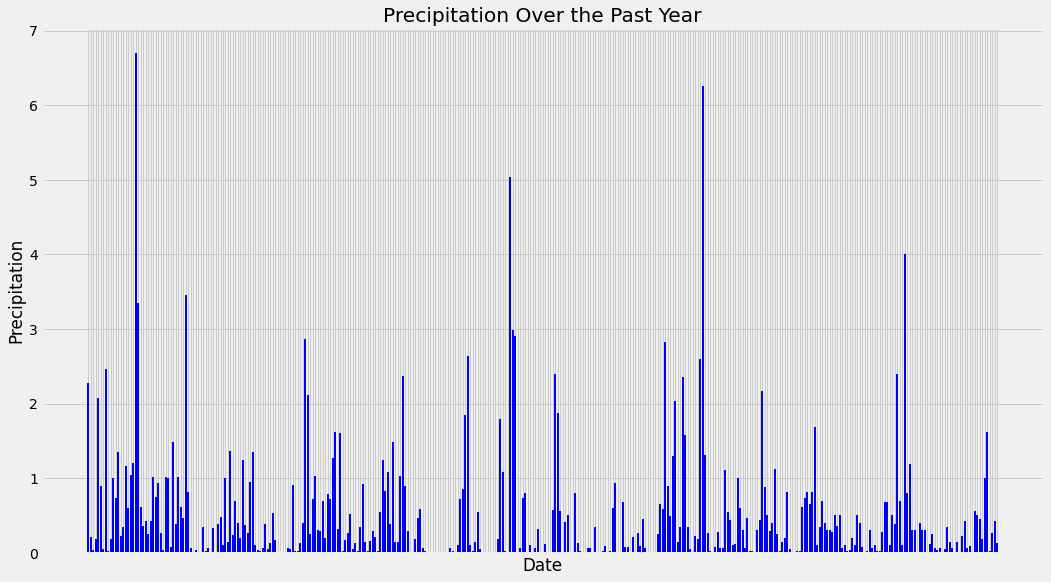

In [107]:
# Perform a query to retrieve the data and precipitation scores
last_year_prcp = session.query(measurement.date, measurement.prcp).filter(measurement.date >= last_year).all()


# Save the query results as a Pandas DataFrame and set the index to the date column
last_year_prcp_df = pd.DataFrame(
    data=last_year_prcp,
    columns=['Date','Precipitation']
)


# Sort the dataframe by date
last_year_prcp_df.sort_values(by=['Date'])


# Drop N/A's
last_year_prcp_df = last_year_prcp_df.dropna()


# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(16,9))
plt.bar(
    x=last_year_prcp_df['Date'], 
    height=last_year_prcp_df['Precipitation'], color='blue')
plt.xlabel("Date")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False  # labels along the bottom edge are off
)
plt.ylabel("Precipitation")
plt.title("Precipitation Over the Past Year")
plt.show()

In [56]:
# Use Pandas to calculate the summary statistics for the precipitation data
last_year_prcp_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [59]:
# Design a query to calculate the total number stations in the dataset
station_count = session.query(station).count()
print(f"Total number of stations: {station_count}")

Total number of stations: 9


In [78]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
most_active_stations = session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [94]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).order_by(func.count(measurement.station).desc()).first()[0]
most_active_station

min_temp = round(session.query(func.min(measurement.tobs)).filter(measurement.station == most_active_station).all()[0][0],1)
max_temp = round(session.query(func.max(measurement.tobs)).filter(measurement.station == most_active_station).all()[0][0],1)
avg_temp = round(session.query(func.avg(measurement.tobs)).filter(measurement.station == most_active_station).all()[0][0],1)

print(f"The lowest temperature for station {most_active_station} is: {min_temp}")
print(f"The highest temperature for station {most_active_station} is: {max_temp}")
print(f"The average temperature for station {most_active_station} is: {avg_temp}")

The lowest temperature for station USC00519281 is: 54.0
The highest temperature for station USC00519281 is: 85.0
The average temperature for station USC00519281 is: 71.7


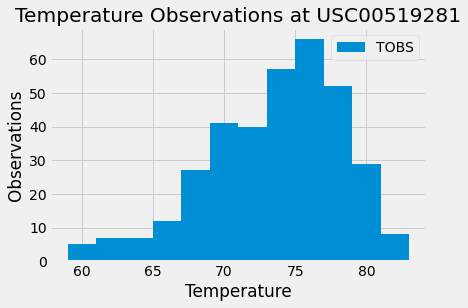

In [106]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_year_temp = session.query(measurement.date, measurement.tobs).filter(measurement.station == most_active_station).filter(measurement.date >= last_year).all()
last_year_temp_df = pd.DataFrame(last_year_temp, columns=['Date','TOBS'])

plt.hist(
    x=last_year_temp_df['TOBS'],
    bins=12,
    label='TOBS'
)
plt.xlabel("Temperature")
plt.ylabel("Observations")
plt.title("Temperature Observations at USC00519281")
plt.legend()
plt.show()

# Close session

In [108]:
# Close Session
session.close()